<!-- File automatically generated using DocOnce (https://github.com/doconce/doconce/):
doconce format ipynb introduction_gpc_v2.do.txt --encoding=utf-8 --ipynb_admon=hrule --ipynb_disable_mpl_inline --ipynb_cite=latex-plain -->

<!-- File automatically generated using DocOnce (https://github.com/doconce/doconce/):
doconce format ipynb introduction_gpc_v2.do.txt --encoding=utf-8 --ipynb_admon=hrule --ipynb_disable_mpl_inline --ipynb_cite=latex-plain

<!-- Polynomial chaos med chaospy -->

**Leif Rune Hellevik**

Date: **January 23, 2026**

# Setup

In [1]:
# --- cell: install_chaospy ---
# @title Install chaospy (Colab-friendly)

try:
    import chaospy as cp
    import numpoly
    import numpy as np
    print("chaospy er allerede installert.")
except ImportError:
    # Installer chaospy fra PyPI. Dette drar inn numpoly automatisk.
    %pip install chaospy==4.3.21 --no-cache-dir
    import chaospy as cp
    import numpoly
    import numpy as np

print("numpy  :", np.__version__)
print("numpoly:", numpoly.__version__)
print("chaospy:", cp.__version__)

chaospy er allerede installert.
numpy  : 2.2.6
numpoly: 1.3.6
chaospy: 4.3.20


In [2]:
# --- cell: repo_setup ---
# @title Repo sync and environment setup

import os
import sys
import subprocess
from pathlib import Path

IN_COLAB = "google.colab" in sys.modules
REMOTE = "https://github.com/lrhgit/uqsa2025.git"
REPO_PATH_COLAB = Path("/content/uqsa2025")

if IN_COLAB:
    if not REPO_PATH_COLAB.exists():
        print("Cloning repository...")
        subprocess.run(
            ["git", "clone", REMOTE, str(REPO_PATH_COLAB)],
            check=True
        )
    else:
        print("Updating existing repository...")
        subprocess.run(
            ["git", "-C", str(REPO_PATH_COLAB), "pull"],
            check=True
        )
    os.chdir(REPO_PATH_COLAB)

# --- Find repo root (works locally + in Colab) ---
cwd = Path.cwd().resolve()
repo_root = next(
    (p for p in [cwd] + list(cwd.parents) if (p / ".git").exists()),
    cwd
)

PY_SRC = repo_root / "python_source"
if PY_SRC.exists() and str(PY_SRC) not in sys.path:
    sys.path.insert(0, str(PY_SRC))

print("CWD:", Path.cwd())
print("repo_root:", repo_root)
print("python_source exists:", PY_SRC.exists())
print("python_source in sys.path:", str(PY_SRC) in sys.path)

CWD: /Users/leifh/git/uqsa2025
repo_root: /Users/leifh/git/uqsa2025
python_source exists: True
python_source in sys.path: True


In [3]:
# --- cell: layout_and_numpy_patch ---
# @title Layout fix, imports, and NumPy compatibility patch

import warnings
warnings.filterwarnings("ignore")

from IPython.display import HTML

HTML("""
<style>
div.cell.code_cell, div.output {
    max-width: 100% !important;
}
</style>
""")

import numpy as np
import matplotlib.pyplot as plt
import chaospy as cp
import numpoly
import pandas as pd


# Pretty-print helpers (used across notebooks)
from pretty_printing import section_title, pretty_table, pretty_print_sobol_mc


# --- NumPy reshape compatibility patch for numpoly ---
_old_reshape = np.reshape

def _reshape_compat(a, *args, **kwargs):
    newshape = None
    if "newshape" in kwargs:
        newshape = kwargs.pop("newshape")
    if "shape" in kwargs and newshape is None:
        newshape = kwargs.pop("shape")
    if newshape is not None:
        return _old_reshape(a, newshape, *args, **kwargs)
    return _old_reshape(a, *args, **kwargs)

np.reshape = _reshape_compat
print("✓ numpy.reshape patched for numpoly compatibility")

✓ numpy.reshape patched for numpoly compatibility


In [4]:
# imports for gpc
import math

# Chaospy
<span id="sec:chaospy"></span>

An introductory paper to the package `chaospy` including a comparison
to other software packages for polynomial chaos expansions may be
found in ([[1]](#feinberg_2015)).  A generic introduction, tutorials and
the source code for `chaospy` is available at:
https://github.com/jonathf/chaospy.

Once the package is installed at your sysstem you may import it simply by

        import chaospy as cp


It is common practice ot "import as cp" as every funtion from chaospy
must be prefixed with `cp.` and in this way it will be convenient to
see whenever a method of the package is applied.

The package `chaospy` is doc-string annotated which means that every method provides a short help text with small examples.
To show the method documentation simply type a `?` after the method name in a ipython console or notebook.
As shown in the following two examples:

In [5]:
# show help for uniform distributions
cp.Uniform?

# show help for sample generation
cp.samplegen?

Object `cp.samplegen` not found.


Init signature: cp.Uniform(lower=0.0, upper=1.0)
Docstring:     
Uniform probability distribution.

Args:
    lower (float, Distribution):
        Lower threshold of distribution. Must be smaller than ``upper``.
    upper (float, Distribution):
        Upper threshold of distribution.

Examples:
    >>> distribution = chaospy.Uniform(2, 4)
    >>> distribution
    Uniform(lower=2, upper=4)
    >>> uloc = numpy.linspace(0, 1, 6)
    >>> uloc
    array([0. , 0.2, 0.4, 0.6, 0.8, 1. ])
    >>> xloc = distribution.inv(uloc)
    >>> xloc.round(3)
    array([2. , 2.4, 2.8, 3.2, 3.6, 4. ])
    >>> numpy.allclose(distribution.fwd(xloc), uloc)
    True
    >>> distribution.pdf(xloc).round(3)
    array([0.5, 0.5, 0.5, 0.5, 0.5, 0.5])
    >>> distribution.sample(4).round(3)
    array([3.307, 2.23 , 3.901, 2.964])
    >>> distribution.mom(1).round(4)
    np.float64(3.0)
    >>> distribution.ttr([0, 1, 2, 3]).round(4)
    array([[ 3.    ,  3.    ,  3.    ,  3.    ],
           [-0.    ,  0.3333,  0.

## Steps for polynomial chaos analysis with chaospy
<span id="sec:StepsCP"></span>

To conduct UQSA analysis with polynomial chaos we need to follow the following steps:

* Definition of the marginal and joint distributions

* Generation of the orthogonal polynomials

* Linear regression

  * Generation of samples

  * `Evaluation of the model for all samples`

  * Generation of the polynomial chaos expansion

* Pseudo-spectral projection

  * Generation of integration nodes and weights

  * `Evaluation of the model for all nodes`

  * Generation of the polynomial chaos expansion

* Calculations of all statistics

Note, that steps  **3 Linear regression**  and **4 Pseudo-spectral projection** are interchangeable. They are simply different methods of cacluating the expansion coefficients. In both cases
generate a set of points in the parameter space where the model must be evaluated (steps 3.b and 4.b, respectively).

## Step 1: Definition of marginal and joint distributions
<span id="sec:distributions"></span>

The analysis of a each model starts with the definition of the marginal distributions for each random model input, i.e. describing it as
random variable.
Univariate random variables can be defined with `chaospy` by calling the class-constructor of a distribution type, e.g `cp.Normal()`, with arguments to describe the particular distribution, e.g. mean value and standard deviation for `cp.Normal`.
The help function can be used to find out more about the required arguments, e.g. `help(cp.Normal)`.

In the following an example for 3 random variables with uniform, normal and log-normal distribution:

In [6]:
# simple distributions
rv1 = cp.Uniform(0, 1)
rv2 = cp.Normal(0, 1)
rv3 = cp.LogNormal(0, 1, 0.2, 0.8)
print(rv1, rv2, rv3)

Uniform() Normal(mu=0, sigma=1) LogNormal(mu=0, sigma=1, scale=0.8, shift=0.2)


After all random input variables are defined with univariate random variables a multi-variate random variable and its joint distribution
can be constructed with the following command:

In [7]:
# joint distributions
joint_distribution = cp.J(rv1, rv2, rv3)
print(joint_distribution)

J(Uniform(), Normal(mu=0, sigma=1), LogNormal(mu=0, sigma=1, scale=0.8, shift=0.2))


It is also possible to construct independent identical distributed random variables from any univariate variable:

In [8]:
# creating iid variables
X = cp.Normal()
Y = cp.Iid(X, 4)
print(Y)

Iid(Normal(mu=0, sigma=1), 4)


## Steps for polynomial chaos analysis with chaospy
<span id="sec:uqsaChaospy"></span>

To conduct UQSA analysis with polynomial chaos we need to follow the following steps:

* Definition of the marginal and joint distributions

* Generation of the orthogonal polynomials

* Linear regression

  * Generation of samples

  * `Evaluation of the model for all samples`

  * Generation of the polynomial chaos expansion

* Pseudo-spectral projection

  * Generation of integration nodes and weights

  * `Evaluation of the model for all nodes`

  * Generation of the polynomial chaos expansion

* Calculations of all statistics

Note, that steps  **3 Linear regression**  and **4 Pseudo-spectral projection** are interchangeable. They are simply different methods of cacluating the expansion coefficients. In both cases
generate a set of points in the parameter space where the model must be evaluated (steps 3.b and 4.b, respectively).

## Step 1: Definition of marginal and joint distributions
<span id="sec:marg_istributions"></span>

The analysis of a each model starts with the definition of the marginal distributions for each random model input, i.e. describing it as
random variable.
Univariate random variables can be defined with `chaospy` by calling the class-constructor of a distribution type, e.g `cp.Normal()`, with arguments to describe the particular distribution, e.g. mean value and standard deviation for `cp.Normal`.
The help function can be used to find out more about the required arguments, e.g. `help(cp.Normal)`.

In the following an example for 3 random variables with uniform, normal and log-normal distribution:

In [9]:
# simple distributions
rv1 = cp.Uniform(0, 1)
rv2 = cp.Normal(0, 1)
rv3 = cp.LogNormal(0, 1, 0.2, 0.8)
print(rv1, rv2, rv3)

Uniform() Normal(mu=0, sigma=1) LogNormal(mu=0, sigma=1, scale=0.8, shift=0.2)


After all random input variables are defined with univariate random variables a multi-variate random variable and its joint distribution
can be constructed with the following command:
<!-- @@@CODE ./python_source/introduction_chaospy.py fromto: # joint distributions@# end joint distributions -->

It is also possible to construct independent identical distributed random variables from any univariate variable:
<!-- @@@CODE ./python_source/introduction_chaospy.py fromto: # creating iid variables@# end creating iid variables -->

## Step 2: Orthogonal Polynomials
<span id="sec:orthogonalPolynomials"></span>

The orthogonal polynomials can be generated with different methods, in `chaospy` there are 4 methods implemented. The
most stable method, and therefore most advised is the *three terms recursion* method.

<table class="dotable" border="1">
<thead>
<tr><th align="center">        Orthogonalization Method        </th> <th align="center">     chaospy function    </th> </tr>
</thead>
<tbody>
<tr><td align="center">   Cholesky decomposition                      </td> <td align="center">   cp.expansion.cholesky        </td> </tr>
<tr><td align="center">   Three terms recursion (Stieltjes method)    </td> <td align="center">   cp.expansion.stieltjes       </td> </tr>
<tr><td align="center">   Modified Gram–Schmidt                       </td> <td align="center">   cp.expansion.gram_schmidt    </td> </tr>
</tbody>
</table>

Regarding the *three terms recursion* method:
For the distributions Normal, Uniform, Gamma, Log-normal, Triangle, Beta and stochastic independent variable combinations of those,
the three terms recursion coefficients are known.
For all other distributions the coefficients are estimated numerically.
The *three terms recursion* method is then also called **discretized stieltjes method**.

The most stable method and therefore most applied method is the **three terms recursion** (**discretized stieltjes method**) method.

We will look at all in a small example, try to increase the polynomial order and the instabilities of the methods become visible.

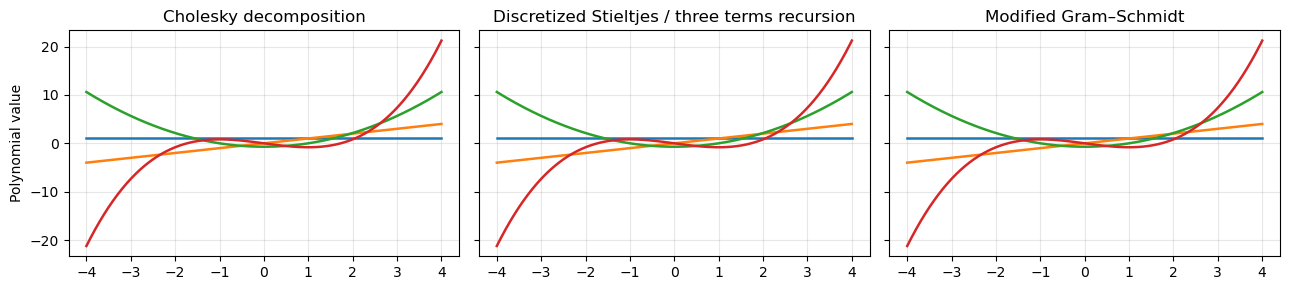

In [10]:
# example orthogonalization schemes
from pretty_polynomial import poly_overview_cell
import chaospy as cp
import numpy as np

dist = cp.Normal(0, 1)
order = 3
x = np.linspace(-4, 4, 400)

poly_overview_cell(cp, dist, order, x=x, normed=True, var="q", decimals=3)

## Step 3.: Linear regression

The linear regression method requires to conduct the three following steps:

1. Generation of samples

2. `Evaluation of the model for all samples`

3. Generation of the polynomial chaos expansion

In the following we will not consider the model evaluation.

### Step 3.a: Sampling

<span id="sec:sampling"></span>

Once a random variable is defined or a joint random variable, also referred as distribution here, the following
method can be used to generate as set of samples:

In [11]:
# sampling in chaospy
u = cp.Uniform(0,1)
u.sample?

Signature:
u.sample(
    size=(),
    rule='random',
    antithetic=None,
    include_axis_dim=False,
    seed=None,
)
Docstring:
Create pseudo-random generated samples.

By default, the samples are created using standard (pseudo-)random
samples. However, if needed, the samples can also be created by either
low-discrepancy sequences, and/or variance reduction techniques.

Changing the sampling scheme, use the following ``rule`` flag:

----------------------  -------------------------------------------
key                     description
----------------------  -------------------------------------------
``additive_recursion``  Modulus of golden ratio samples.
``chebyshev``           Roots of first order Chebyshev polynomials.
``grid``                Regular spaced grid.
``halton``              Halton low-discrepancy sequence.
``hammersley``          Hammersley low-discrepancy sequence.
``korobov``             Korobov lattice.
``latin_hypercube``     Latin hypercube samples.
``nested_ch

The method takes the arguments **size** which is the number of samples and **rule** which is the applied sampling scheme.
The following example shows the creation of 2 set of samples for the sampling schemes *(Pseudo-)Random* and *Hammersley*.

In [12]:
# example sampling with plots

import chaospy as cp
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets

u1 = cp.Uniform(0, 1)
u2 = cp.Uniform(0, 1)
joint = cp.J(u1, u2)

def plot_sampling(N=200):
    s_r = joint.sample(size=N, rule="random")
    s_h = joint.sample(size=N, rule="hammersley")

    fig, ax = plt.subplots(1, 2, figsize=(10, 4), sharex=True, sharey=True, constrained_layout=True)

    ax[0].scatter(*s_r, s=10)
    ax[0].set_title(f"Random (N={N})")
    ax[0].set_xlabel("Uniform 1"); ax[0].set_ylabel("Uniform 2")
    ax[0].set_aspect("equal", adjustable="box")

    ax[1].scatter(*s_h, s=10)
    ax[1].set_title(f"Hammersley (N={N})")
    ax[1].set_xlabel("Uniform 1")
    ax[1].set_aspect("equal", adjustable="box")

    plt.show()
    plt.close(fig)

widgets.interact(
    plot_sampling,
    N=widgets.IntSlider(value=200, min=20, max=1000, step=20, description="N", continuous_update=False)
);

interactive(children=(IntSlider(value=200, continuous_update=False, description='N', max=1000, min=20, step=20…

All sampling schemes implemented in chaospy are listed in the following table:

<table class="dotable" border="1">
<thead>
<tr><th align="center">Key</th> <th align="center">      Name      </th> <th align="center">Nested</th> </tr>
</thead>
<tbody>
<tr><td align="center">   C      </td> <td align="center">   Chebyshev nodes     </td> <td align="center">   no        </td> </tr>
<tr><td align="center">   NC     </td> <td align="center">   Nested Chebyshev    </td> <td align="center">   yes       </td> </tr>
<tr><td align="center">   K      </td> <td align="center">   Korobov             </td> <td align="center">   no        </td> </tr>
<tr><td align="center">   R      </td> <td align="center">   (Pseudo-)Random     </td> <td align="center">   no        </td> </tr>
<tr><td align="center">   RG     </td> <td align="center">   Regular grid        </td> <td align="center">   no        </td> </tr>
<tr><td align="center">   NG     </td> <td align="center">   Nested grid         </td> <td align="center">   yes       </td> </tr>
<tr><td align="center">   L      </td> <td align="center">   Latin hypercube     </td> <td align="center">   no        </td> </tr>
<tr><td align="center">   S      </td> <td align="center">   Sobol               </td> <td align="center">   yes       </td> </tr>
<tr><td align="center">   H      </td> <td align="center">   Halton              </td> <td align="center">   yes       </td> </tr>
<tr><td align="center">   M      </td> <td align="center">   Hammersley          </td> <td align="center">   yes       </td> </tr>
</tbody>
</table>

### Step 3.c: Polynomial Chaos Expansion

After the model is evaluated for all samples, the polynomial chaos expansion can be generated with the following method:

In [13]:
# linear regression in chaospy
cp.fit_regression?

Signature: cp.fit_regression(polynomials, abscissas, evals, model=None, retall=0)
Docstring:
Fit a polynomial chaos expansion using linear regression.

Args:
    polynomials (numpoly.ndpoly):
        Polynomial expansion with ``polynomials.shape == (M,)`` and
        `polynomials.dim=D`.
    abscissas (numpy.ndarray):
        Collocation nodes with ``abscissas.shape == (D, K)``.
    evals (numpy.ndarray):
        Model evaluations with ``len(evals) == K``.
    model (Optional[sklearn.base.BaseEstimator]):
        By default regression is done using the classical least-square
        method. However, if provided, and `sklearn` regression model can be
        used instead.
    retall (int):
        What the function should return.
        0: only return fitted polynomials, with shape `evals.shape[1:]`.
        1: polynomials, and Fourier coefficients,
        2: polynomials, coefficients and polynomial evaluations.

Returns:
    (chaospy.ndpoly, numpy.ndarray, numpy.ndarray):
        Ret

In the following we show a complete example for polynomial chaos expansion using the linear regression.
The model applied the very simple mathematical expression:

<!-- Equation labels as ordinary links -->
<div id="eq:dummy_model"></div>

$$
\begin{equation}
 y(z_1, z_2) = z_1 + z_1 z_2
\label{eq:dummy_model} \tag{1}
\end{equation}
$$

The random variables for $Z_1, Z_2$ are defined as simple uniform random variables:

<!-- Equation labels as ordinary links -->
<div id="eq:dummy_rv"></div>

$$
\begin{equation}
Z_1 = \mbox{U}(0,1), \quad Z_2 = \mbox{U}(0,1)
\label{eq:dummy_rv} \tag{2}
\end{equation}
$$

The mean of this should be $\frac{3}{4}$, the variance should be $\frac{31}{144}$ and the sensitivites to $Z_1$ and $Z_2$ are respectively $\frac{3}{31}$ and $\frac{27}{31}$.

Here is the annotated example code with all steps required to generate a polynomial chaos expansion with
linear regression:

In [14]:
# example linear regression
# 1. define marginal and joint distributions
u1 = cp.Uniform(0,1)
u2 = cp.Uniform(0,1)
joint_distribution = cp.J(u1, u2)

# 2. generate orthogonal polynomials
polynomial_order = 3
poly = cp.expansion.stieltjes(polynomial_order, joint_distribution)

# 3.1 generate samples

number_of_samples = math.comb(
    polynomial_order + len(joint_distribution),
    len(joint_distribution),
)
samples = joint_distribution.sample(size=number_of_samples, rule='R')

# 3.2 evaluate the simple model for all samples
model_evaluations = samples[0]+samples[1]*samples[0]

# 3.3 use regression to generate the polynomial chaos expansion
gpce_regression = cp.fit_regression(poly, samples, model_evaluations)
print("Success")

Success


## Step 4: Pseudo-spectral projection

### Step 4.a: Quadrature nodes and weights

<span id="sec:quadrature"></span>

Once a random variable is defined or joint random variables, also referred as distribution here, the following
method can be used to generate nodes and weights for different quadrature methods:

In [15]:
# quadrature in polychaos
cp.generate_quadrature?

Signature:
cp.generate_quadrature(
    order,
    dist,
    rule=None,
    sparse=False,
    growth=None,
    segments=1,
    recurrence_algorithm='stieltjes',
    tolerance=1e-10,
    scaling=3,
    n_max=5000,
)
Docstring:
Numerical quadrature node and weight generator.

Args:
    order (int):
        The order of the quadrature.
    dist (chaospy.distributions.baseclass.Distribution):
        The distribution which density will be used as weight function.
    rule (str, Sequence[str], None):
        Rule for generating abscissas and weights. If one name is provided,
        that rule is applied to all dimensions. If multiple names, each
        rule is positionally applied to each dimension. If omitted,
        ``clenshaw_curtis`` is applied to all continuous dimensions, and
        ``discrete`` to all discrete ones.
    sparse (bool):
        If True used Smolyak's sparse grid instead of normal tensor product
        grid.
    growth (bool, None):
        If True sets the growth ru

We will look at the following arguments of the method: **order** is the order of the quadrature, **domain** is
the , **rule** is the *name* or *key* of the quadrature rule to apply.

In the following example we look at some quadrature nodes for the same uniform variables as for the sampling,
for Optimal Gaussian quadrature and Clenshaw-Curtis quadrature.

Number of nodes gaussian quadrature: 36
Number of nodes clenshaw-curtis quadrature: 36


(np.float64(-0.05), np.float64(1.05), np.float64(-0.05), np.float64(1.05))

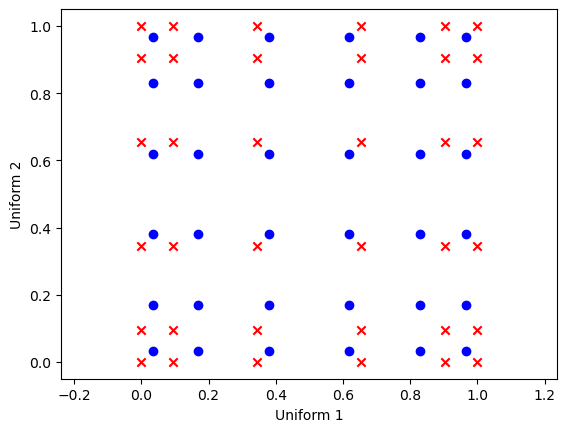

In [16]:
# example quadrature
u1 = cp.Uniform(0,1)
u2 = cp.Uniform(0,1)
joint_distribution = cp.J(u1, u2)

order = 5


nodes_gaussian, weights_gaussian = cp.generate_quadrature(
    order=order,
    dist=joint_distribution,
    rule="G",
)

nodes_clenshaw, weights_clenshaw = cp.generate_quadrature(
    order=order,
    dist=joint_distribution,
    rule="C",
)


print('Number of nodes gaussian quadrature: {}'.format(len(nodes_gaussian[0])))
print('Number of nodes clenshaw-curtis quadrature: {}'.format(len(nodes_clenshaw[1])))


fig1, ax1 = plt.subplots()
ax1.scatter(*nodes_gaussian, marker='o', color='b')
ax1.scatter(*nodes_clenshaw, marker= 'x', color='r')
ax1.set_xlabel("Uniform 1")
ax1.set_ylabel("Uniform 2")
ax1.axis('equal')

In the following all quadrature rules implemented in chaospy are highlighted:

<table class="dotable" border="1">
<thead>
<tr><th align="center"> Collection of quadrature rules</th> <th align="center">   Name  </th> <th align="center">Key</th> </tr>
</thead>
<tbody>
<tr><td align="center">   Optimal Gaussian quadrature        </td> <td align="center">   Gaussian     </td> <td align="center">   G      </td> </tr>
<tr><td align="center">   Gauss-Legendre quadrature          </td> <td align="center">   Legendre     </td> <td align="center">   E      </td> </tr>
<tr><td align="center">   Clenshaw-Curtis quadrature         </td> <td align="center">   Clenshaw     </td> <td align="center">   C      </td> </tr>
<tr><td align="center">   Leja quadrature                    </td> <td align="center">   Leja         </td> <td align="center">   J      </td> </tr>
<tr><td align="center">   Hermite Genz-Keizter 16 rule       </td> <td align="center">   Genz         </td> <td align="center">   Z      </td> </tr>
<tr><td align="center">   Gauss-Patterson quadrature rule    </td> <td align="center">   Patterson    </td> <td align="center">   P      </td> </tr>
</tbody>
</table>

It is also possible to use sparse grid quadrature. For this purpose Clenshaw-Curtis method is advised since it is nested.

In the following example we show sparse vs. normal quadrature nodes:

Number of nodes normal clenshaw-curtis quadrature: 9
Number of nodes clenshaw-curtis quadrature with sparse grid : 13


(np.float64(-0.05), np.float64(1.05), np.float64(-0.05), np.float64(1.05))

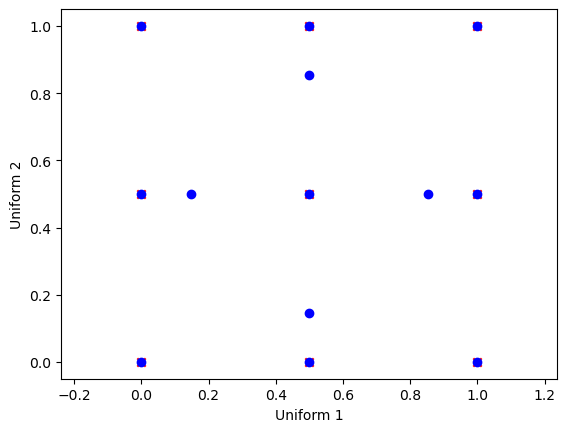

In [17]:
# example sparse grid quadrature
u1 = cp.Uniform(0,1)
u2 = cp.Uniform(0,1)
joint_distribution = cp.J(u1, u2)

order = 2
# sparse grid has exponential growth, thus a smaller order results in more points
nodes_clenshaw, weights_clenshaw = cp.generate_quadrature(
    order=order, dist=joint_distribution, rule="C"
)
nodes_clenshaw_sparse, weights_clenshaw_sparse = cp.generate_quadrature(
    order=order, dist=joint_distribution, rule="C", sparse=True
)


print('Number of nodes normal clenshaw-curtis quadrature: {}'.format(len(nodes_clenshaw[0])))
print('Number of nodes clenshaw-curtis quadrature with sparse grid : {}'.format(len(nodes_clenshaw_sparse[0])))

fig1, ax1 = plt.subplots()
ax1.scatter(*nodes_clenshaw, marker= 'x', color='r')
ax1.scatter(*nodes_clenshaw_sparse, marker= 'o', color='b')
ax1.set_xlabel("Uniform 1")
ax1.set_ylabel("Uniform 2")
ax1.axis('equal')

### Step 4.c: Polynomial Chaos Expansion

After the model is evaluated for all integration nodes, the polynomial chaos expansion can be generated with the following method:

In [18]:
# spectral projection in chaospy
cp.fit_quadrature?

Signature: cp.fit_quadrature(orth, nodes, weights, solves, retall=False, norms=None)
Docstring:
Fit polynomial chaos expansion using spectral projection.

Create a polynomial approximation model from orthogonal expansion,
quadrature nodes and weights.

Args:
    orth (numpoly.ndpoly):
        Orthogonal polynomial expansion. Must be orthogonal for the
        approximation to be accurate.
    nodes (numpy.ndarray):
        Where to evaluate the polynomial expansion and model to
        approximate. ``nodes.shape==(D, K)`` where ``D`` is the number of
        dimensions and ``K`` is the number of nodes.
    weights (numpy.ndarray):
        Weights when doing numerical integration. ``weights.shape == (K,)``
        must hold.
    solves (numpy.ndarray):
        The model evaluation to approximate. If `numpy.ndarray` is
        provided, it must have ``len(solves) == K``.
    retall (int):
        What the function should return.
        0: only return fitted polynomials, with shape `eval

In the following we show again a complete example for polynomial chaos expansion using the pseudo spectral approach to calculate the
expansion coefficients.
The model applied the same simple mathematical expression as before:

<!-- Equation labels as ordinary links -->
<div id="eq:dummy_model_repeat"></div>

$$
\begin{equation}
 y(z_1, z_2) = z_1 + z_1 z_2
\label{eq:dummy_model_repeat} \tag{3}
\end{equation}
$$

The random variables for $Z_1, Z_2$ are defined as simple uniform random variables:

<!-- Equation labels as ordinary links -->
<div id="eq:dummy_rv_repeat"></div>

$$
\begin{equation}
Z_1 = \mbox{U}(0,1), \quad Z_2 = \mbox{U}(0,1)
\label{eq:dummy_rv_repeat} \tag{4}
\end{equation}
$$

In [19]:
# example spectral projection
# 1. define marginal and joint distributions
u1 = cp.Uniform(0,1)
u2 = cp.Uniform(0,1)
joint_distribution = cp.J(u1, u2)

# 2. generate orthogonal polynomials
polynomial_order = 3
poly = cp.expansion.stieltjes(polynomial_order, joint_distribution)

# 4.1 generate quadrature nodes and weights
order = 5
nodes, weights = cp.generate_quadrature(
    order=order,
    dist=joint_distribution,   # <-- was: domain=joint_distribution
    rule="G"                   # gaussian quadrature (can also use "C", "E", etc.)
)


# 4.2 evaluate the simple model for all nodes
model_evaluations = nodes[0]+nodes[1]*nodes[0]

# 4.3 use quadrature to generate the polynomial chaos expansion
gpce_quadrature = cp.fit_quadrature(poly, nodes, weights, model_evaluations)
print("Success")

Success


## Step 5: Statistical Analysis
<span id="sec:statistical_analysis"></span>

Once the polynomial chaos expansion is created either with **pseudo-spectral projection** or with **regression** method
The calculation of statistics is straight forward.
The following listing gives an overview of all available methods take all the same input parameter the **polynomial-expansion** and
the **joint-distribution** (see also example below).

Note, that one can also calculate uncertainty statistics on distributions only as well.

### Uncertainty quantification

* Expected value: `cp.E`

* Variance: `cp.Var`

* Standard deviation: `cp.Std`

* Curtosis: `cp.Kurt`

* Skewness: `cp.Skew`

* Distribution of Y: `cp.QoI_Dist`

* Prediction intervals: `cp.Perc`, which is a method to calculate percentiles: an additional argument defining the percentiles needs to be passed.

If multiple quantities of interest are available:

* Covariance matrix: `cp.Cov`

* Correlation matrix: `cp.Corr`

* Spearman correlation: `cp.Spearman`

* Auto-correlation function: `cp.Acf`

In [20]:
# example uq
# Expected value
exp_reg = cp.E(gpce_regression, joint_distribution)
exp_ps  = cp.E(gpce_quadrature,  joint_distribution)

# Standard deviation
std_reg = cp.Std(gpce_regression, joint_distribution)
std_ps  = cp.Std(gpce_quadrature,  joint_distribution)

# Prediction intervals (90%)
pred_reg = cp.Perc(gpce_regression, [5, 95], joint_distribution)
pred_ps  = cp.Perc(gpce_quadrature,  [5, 95], joint_distribution)

# Assemble table
df_stats = pd.DataFrame(
    {
        "E (regression)": [f"{exp_reg:.3f}"],
        "E (projection)": [f"{exp_ps:.3f}"],
        "Std (regression)": [f"{std_reg:.3f}"],
        "Std (projection)": [f"{std_ps:.3f}"],
        "PI 5–95% (regression)": [f"[{pred_reg[0]:.3f}, {pred_reg[1]:.3f}]"],
        "PI 5–95% (projection)": [f"[{pred_ps[0]:.3f}, {pred_ps[1]:.3f}]"],
    },
    index=["Y"]
)

display(section_title("Uncertainty statistics from PCE"))
pretty_table(df_stats)

,E (regression),E (projection),Std (regression),Std (projection),PI 5–95% (regression),PI 5–95% (projection)
Y,0.750,0.750,0.464,0.464,"[0.070, 1.580]","[0.071, 1.568]"


### Sensitivity analysis

The variance bases sensitivity indices can be calculated directly from the expansion.
The `chaospy` package provides the following methods:

* first order indices: `cp.Sens_m`

* second order indices: `cp.Sens_m2`

* total indices: `cp.Sens_t`

Here is an example for the first and total indices for both expansions:

In [21]:
# example sens
sensFirst_reg = cp.Sens_m(gpce_regression, joint_distribution)
sensFirst_ps = cp.Sens_m(gpce_quadrature, joint_distribution)

sensT_reg = cp.Sens_t(gpce_regression, joint_distribution)
sensT_ps = cp.Sens_t(gpce_quadrature, joint_distribution)

# Assemble table
df_sens = pd.DataFrame(
    {
        "S (regression)": sensFirst_reg,
        "S (projection)": sensFirst_ps,
        "ST (regression)": sensT_reg,
        "ST (projection)": sensT_ps,
    },
    index=[f"X{i+1}" for i in range(len(sensFirst_reg))]
).round(3)

display(section_title("Sensitivity indices from PCE"))
pretty_table(df_sens)

,S (regression),S (projection),ST (regression),ST (projection)
X1,0.871,0.871,0.903,0.903
X2,0.097,0.097,0.129,0.129


# References

1. <span id="feinberg_2015"></span> **J. Feinberg and H. P. Langtangen**.  Chaospy: an Open Source Tool for Designing Methods of Uncertainty Quantification, *Journal of Computational Science*, 11, pp. 46-57, 2015.